In [4]:
'''
This code is written for the course Numerical Methods for Dynamics given at the TU Delft.
The code solves, as an example, the Eigenvalues and Eigenmodes of a simple triangular structure 
consisting of beam elements, the Bar element is to be added by the students.

Contributers:
Arts, Sebastian
Gadi, Ratnakar
van Schoubroeck, Jimmy
Verboom, Jeroen

For people seeking an introduction to Python, have a look at the codeacademy.com or learnpythonthehardway.org/book/

The following steps are carried out by the code:
1. Call geometric classes (Square, Circle) to create elements.
2. Call Material class to create material.
3. Call Node/Element class to create elements.
4. Call Mesh class to create global stiffness and mass matrix.
5. Call EigenSolution class to solve for Eigenvalues/modes.
6. Call Plot class to create a plot of your structure
 '''

import numpy as np
from types import SimpleNamespace
from scipy import linalg, sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

############################## Cross Section Classes 
############################## Basic Circle and Square 

class Square:
    """Creating a Square profile"""
    def __init__(self, d_outer=0, d_inner=0):
        self.d_outer = d_outer
        self.d_inner = d_inner
        self.A = self.d_outer** 2 - self.d_inner ** 2
        self.I_x = self.I_y = self.I_z = (self.d_outer ** 4) / 12 - (self.d_inner - self.d_outer ** 4) / 12
        self.thickness = d_outer - d_inner
        self.J_x = self.thickness * (d_outer - self.thickness) * (d_outer - self.thickness) ** 2
        
class Circle:
    """Creating a circular parameter"""
    def __init__(self, d_outer=0, d_inner=0):
        self.d_outer = d_outer
        self.d_inner = d_inner
        self.A = 0.25 * np.pi * (self.d_outer ** 2 - self.d_inner ** 2)
        self.I_x = self.I_y = self.I_z = np.pi/64 * (self.d_outer ** 4 - self.d_inner ** 4)
        self.J_x = np.pi/32 * (self.d_outer ** 4 - self.d_inner ** 4)
        

############################## Node Class
############################## Assigning Nodes

class Node:
    """Node class represents and manipulates the x, y and z coordinates of nodes"""
    def __init__(self, number_of_nodes=1):
        """Creation of n by 3 matrix with n nodes and 3 coordinates"""
        self.matrix = np.zeros((number_of_nodes, 3))


############################## Material Class
############################## Assigning Material

class Material:
    '''Generate a material with inputs E, Rho and nu'''   
    def __init__(self, E, Rho, nu):
        self.E = E
        self.Rho = Rho
        self.nu = nu
        self.G = E / (2 * (1 + nu ))


############################## Beam Class 
############################## Set-up of local beam matrices 

class Beam:
    """This class constructs the mass and stiffness matrix for beam elements"""

    def __init__(self, material=None, nodes=np.zeros((3, 3)), profile=None, r2=0):
        self.E = material.E
        self.Rho = material.Rho
        self.G = material.G
        self.nodes = nodes
        self.A = profile.A
        self.I_x = profile.I_x
        self.I_y = profile.I_y
        self.I_z = profile.I_z
        self.r2 = (self.I_y + self.I_z) / self.A
        self.J_x = profile.J_x


    def KM(self):
        """Returns the K and M matrix"""

        L = np.linalg.norm(self.nodes[0] - self.nodes[1])

        if L == 0:
            print("Beam has zero length, Node 1: {}, Node 2: {}".format(self.nodes[0], self.nodes[1]))

        kLocal = np.zeros((12, 12))
        temp = np.array([[1, -1], [-1, 1]])
        kLocal[np.ix_([0, 6], [0, 6])] = (self.E * self.A / L) * temp
        kLocal[np.ix_([3, 9], [3, 9])] = (self.J_x * self.G / L) * temp

        stiffness1 = np.array([[12, 6 * L, -12, 6 * L],
                               [6 * L, 4 * L**2, -6 * L, 2 * L**2],
                               [-12, -6 * L, 12, -6 * L],
                               [6 * L, 2 * L**2, -6 * L, 4 * L**2]])
        stiffness2 = np.array([[12, -6 * L, -12, -6 * L],
                               [-6 * L, 4 * L**2, 6 * L, 2 * L**2],
                               [-12, 6 * L, 12, 6 * L],
                               [-6 * L, 2 * L**2, 6 * L, 4 * L**2]])

        kLocal[np.ix_([1, 5, 7, 11], [1, 5, 7, 11])] = (self.E / (L ** 3)) * self.I_z * stiffness1
        kLocal[np.ix_([2, 4, 8, 10], [2, 4, 8, 10])] = (self.E / (L ** 3)) * self.I_y * stiffness2

        mLocal = np.zeros((12, 12))
        temp2 = np.array([[2, 1], [1, 2]])
        mLocal[np.ix_([3, 9], [3, 9])] = self.Rho * self.A * L * (self.r2 / 6) * temp2
        mLocal[np.ix_([0, 6], [0, 6])] = self.Rho * self.A * (L / 6) * temp2

        mass1 = np.array([[156, 22 * L, 54, -13 * L],
                          [22 * L, 4 * L**2, 13 * L, -3 * L**2],
                          [54, 13 * L, 156, -22 * L],
                          [-13 * L, -3 * L**2, -22 * L, 4 * L**2]])
        mass2 = np.array([[156, -22 * L, 54, 13 * L],
                          [-22 * L, 4 * L**2, -13 * L, -3 * L**2],
                          [54, -13 * L, 156, 22 * L],
                          [13 * L, -3 * L**2, 22 * L, 4 * L**2]])
        mLocal[np.ix_([1, 5, 7, 11], [1, 5, 7, 11])] = self.Rho * self.A * ( L / 420 ) * mass1
        mLocal[np.ix_([2, 4, 8, 10], [2, 4, 8, 10])] = self.Rho * self.A * ( L / 420 ) * mass2


        d2 = self.nodes[1] - self.nodes[0]
        e_x = (d2) / L
        d3 = self.nodes[2] - self.nodes[0]
        e_y = np.cross(d3, d2) / np.linalg.norm(np.cross(d3, d2))
        e_z = np.cross(e_x, e_y)

        r = np.array([[e_x[0], e_x[1], e_x[2]], [e_y[0], e_y[1], e_y[2]], [e_z[0], e_z[1], e_z[2]]])
        tM = np.zeros((12, 12))
        tM[0:3, 0:3] = tM[3:6, 3:6] = tM[6:9, 6:9] = tM[9:12, 9:12] = r

        kElement = tM.conj().T @ kLocal @ tM
        mElement = tM.conj().T @ mLocal @ tM

        return kElement, mElement


############################## Element Class 
############################## Assigning Nodes 

class Element:
    """Element class represents and manipulates the x, y and z coordinates of nodes"""
    def __init__(self, number_of_elements=1):
        """Creation of n by 3 matrix with n nodes and 3 coordinates"""
        self.lists = []
        self.matrix = [self.lists.append([]) for x in (range(number_of_elements))] # In this property n lists are made according to the number of nodes to be added


############################## Mesh Class 
############################## Assemble Local Matrices into Global Matrices

class Mesh:
    """Mesh class contains the type of elements (beam/bar), the material and the nodes.
    Furthermore the class has the ability to assemble the stiffness and mass matrix"""

    def __init__(self, elements):
        self.Elements = elements
        self.lists = []
        self.connectivity = [self.lists.append([]) for x in (range(len(self.Elements.matrix)))]
        self.number_of_elements = len(self.Elements.matrix)
    
    def assemble_KM(self, dofFix, fixedNodes):
        """Returns the assembled K and M matrix"""
        temp_node_matrix = np.zeros((self.number_of_elements, 3), dtype = int)
        for i in range(self.number_of_elements):
            temp_node_matrix[i, :] = self.Elements.matrix[i][3][:] 
        
        activeNodes = np.unique(temp_node_matrix[:, [0, 1]]) #Selecting the used nodes
        nDof = len(activeNodes) * 6 #The numer of degrees of freedom
        print("The amount of degrees of freedom are,", nDof)
        locnod = np.zeros((len(activeNodes), 6))
        locnod[activeNodes] = np.arange(0, len(activeNodes) * 6).reshape(3,-1)
        
        k = sparse.lil_matrix((nDof,nDof))
        m = sparse.lil_matrix((nDof,nDof))
        
        for i in range(self.number_of_elements):
            # Specifying the specific element characteristics
            elementType = np.array((self.Elements.matrix[i][0]), dtype = int)
            elementMaterial = self.Elements.matrix[i][1]
            elementProfile = self.Elements.matrix[i][2]
            elementNode0 = Nodes.matrix[self.Elements.matrix[i][3][0]]
            elementNode1 = Nodes.matrix[self.Elements.matrix[i][3][1]]
            elementNode2 = Nodes.matrix[self.Elements.matrix[i][3][2]]
    
            # Building the element matrices
            if elementType == 1: # In case the element is a bar
                print("Bar has not been programmed")
                #  Still to be programmed

            elif elementType == 2: # In case the element is a beam
                beamTemp = Beam(material = elementMaterial, profile = elementProfile)
                beamTemp.nodes[0] = elementNode0
                beamTemp.nodes[1] = elementNode1
                beamTemp.nodes[2] = elementNode2
                kElement, mElement = beamTemp.KM()

                dof = np.array(np.hstack(([locnod[self.Elements.matrix[i][3][0], :], locnod[self.Elements.matrix[i][3][1], :]])),dtype= int)
                
            for q in range(12):
                for w in range(12):
                    k[dof[q],dof[w]] += kElement[q,w]
                    m[dof[q],dof[w]] += mElement[q,w]
            
            # Clean up temporary values
            beamTemp = elementType = elementProfile = kElement = mElement = dof = None
        
        self.kGlobal = k
        self.mGlobal = m
    
        for n in fixedNodes:
            dofFix.append(locnod[n])

        # Create flat list from stacked lists
        dofFix = [item for sublist in dofFix for item in sublist]
        nDofFix = len(dofFix)

        # Removing fixed dof from the total list of dof
        dofRem = list(set(range(1,nDof)) - set(dofFix))
        nDofRem = nDof - nDofFix
 
        # Returning only the remaining dof values of K and M
        return self.kGlobal[np.ix_(dofRem, dofRem)], self.mGlobal[np.ix_(dofRem, dofRem)]
    
    def calc_connectivity(self):
        """Function returns list of elements with which the element is sharing a node.
        The index of the list indicate the element, the first list in this list is the first node, the second the second."""
        for n in range(0, self.number_of_elements):
            temp_1 = []
            temp_2 = []
            for m in range(0, self.number_of_elements):
                if self.Elements.matrix[n][3][0] == self.Elements.matrix[m][3][0] or self.Elements.matrix[n][3][0] == self.Elements.matrix[m][3][1]:
                    temp_1.append(m)
                if self.Elements.matrix[n][3][1] == self.Elements.matrix[m][3][0] or self.Elements.matrix[n][3][1] == self.Elements.matrix[m][3][1]:
                    temp_2.append(m)
            self.connectivity[n] = [temp_1, temp_2]
                
        return self.connectivity

############################## Eigensolver Class 
############################## Solve for eigenvalues/Modes 

class EigenSolution:
    '''Solve Eigenvalues and Vectors for global stiffness K and mass M matrix'''
    def __init__(self,k,m):
        '''Requested variables: k, m '''
        self.k = k.todense()
        self.m = m.todense()
    
    def eig(self):
        ''' Returns Eigenvalues and Eigenvectors'''
        #Omega2, X = np.linalg.eig((self.K,self.M))
        omega2, x = linalg.eig(self.k,self.m,left=False,right=True)
      
        # Sort eigenvalues and place them in a diagonal matrix
        k = range(0,len(omega2))
        omega2.sort()
        omega2 = np.real(omega2)
        
        # Convert eigenvectors to only real solutions and sort accordingly
        x = np.real(x[:,k])
        return x, omega2



#################### Plot Final Mesh  ################################################
######################################################################################

class MeshPlot:  
    '''Plotting Structure using Matplotlibpackage (Not Yet Generalized)'''
    def __init__(self,Nodes,Elements):
        self.nodes = Nodes
        self.elements = Elements

    def Plot(self):
        '''Plotting the structure in 3D'''
        fig = plt.figure()
        ax = fig.gca(projection='3d')
                     
        Nel = len(self.elements.matrix)

        node1 = self.nodes.matrix[0,:]
        node2 = self.nodes.matrix[1,:]
        node3 = self.nodes.matrix[2,:]
        ax.plot(node1,node2,node3,'g*')
        
        x = []
        y = []
        z = []
        
        for el in range(0,Nel):
            type_el = self.elements.matrix[el][0]
            node1 = self.nodes.matrix[self.elements.matrix[el][3][0]]
            node2 = self.nodes.matrix[self.elements.matrix[el][3][1]]
            x.extend((node1[0], node2[0]))
            y.extend((node1[1], node2[1]))
            z.extend((node1[2], node2[2]))
       
        ax.plot(x,y,z,'r')        
        plt.show()




The amount of degrees of freedom are, 18
Connectivity:  [[[0, 2], [0, 1]], [[0, 1], [1, 2]], [[0, 2], [1, 2]]]


<IPython.core.display.Javascript object>


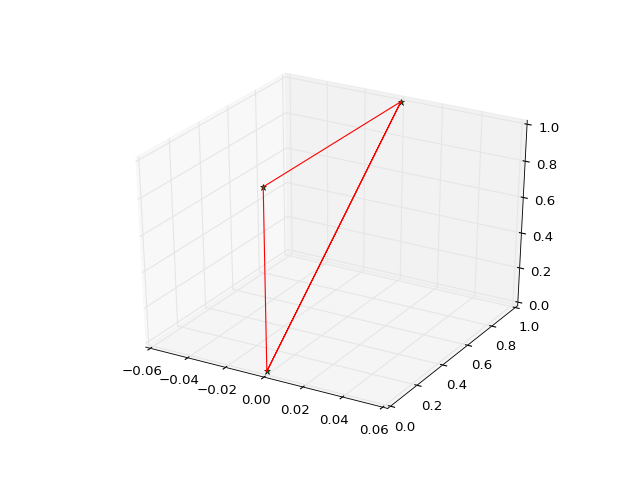

In [7]:
############################## Example how to set up a new structure

## Create instance of material
Steel = Material(210*10**9,7800,0.3) 

## Create instance of profile
profile_1 = Circle(1, .5)

## Create instance of Nodes
Nodes = Node(7)
Nodes.matrix[0] = [0, 0, 0]
Nodes.matrix[1] = [0, 0, 1]
Nodes.matrix[2] = [0, 1, 1]
Nodes.matrix[6] = [0, 1, 0] # Dummy for beam orientation

## Assemble local beams to global matrix
## Create instance of Elements [ElementType, Material, Profile, Coordinates]
Elements = Element(3)
Elements.matrix[0] = [2, Steel, profile_1, [0, 1, 6]]
Elements.matrix[1] = [2, Steel, profile_1, [1, 2, 6]]
Elements.matrix[2] = [2, Steel, profile_1, [0, 2, 6]]
 
## Set the fixed DOF and nodes
fixedNodes = [0]
fixedDof = []    

## Create instance of global stifness/mass matrix, internally calling beam elements  
KM_assy = Mesh(Elements)
k, m = KM_assy.assemble_KM(fixedDof, fixedNodes)
#print(k)

## The connectivity of the elements can be checked
print("Connectivity: ", KM_assy.calc_connectivity())

#print("The size of K = ", len(K), "x", len(K))
# print("kGlobal = ", k)
# print("mGlobal = ", m)

## Calculate eigenvalues of system
Eig = EigenSolution(k,m)
x, omega2 = Eig.eig()
# print("Eigenvectors = ", x)
# print("Eigenvalues = ", omega2)

# ## Plot the structure
plot = MeshPlot(Nodes,Elements)
testplot = plot.Plot()